# 2. Análisis de audios como datos brutos

Se usa el set A del dataset Heartbeat Sounds de Kaggle. El conjunto de entradas corresponde a archivos de audio de latidos de corazón, y la salida esperada es una de 4 categorías: 1. Normal, 2. Murmur, 3. Extra Heart Sound y 4. Artifact. Esta información está contenida en el archivo CSV set_a.csv. Es posible que existan audios sin etiqueta asignada, por lo que se ignorarán. El objetivo de la actividad es diseñar una máquina que aprenda a determinar la categoría correcta para futuras entradas de sonido de latidos de corazón.

In [1]:
from scipy.io import wavfile

def clean_filename(fname, string):
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':
        file_name=string + file_name
    return file_name

SAMPLE_RATE = 44100

def load_wav_file(name, path):
    s, b = wavfile.read(path+name)
    assert s == SAMPLE_RATE
    return b

#### (a) Se construye dataframe con los datos a usar.

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('./heartbeat-sounds/set_a.csv')

In [3]:
df.head(10)

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN
5,a,set_a/artifact__201105061143.wav,artifact,NaN
6,a,set_a/artifact__201105190800.wav,artifact,NaN
7,a,set_a/artifact__201105280851.wav,artifact,NaN
8,a,set_a/artifact__201106010559.wav,artifact,NaN
9,a,set_a/artifact__201106010602.wav,artifact,NaN


Una inspección manual sobre el dataset permite confirmar que existen 176 registros de audio, de los cuales sólo los primeros 124 se encuentran etiquetados. De éstos, hay 40 calificados como 'Artifact', 19 como 'extrahls', 34 como 'murmur' y 31 como 'normal'. Durante el ejercicio, no se usarán las columnas 'set' ni 'sublabel', por lo que se eliminarán del dataframe.

In [4]:
df = df.drop(['dataset','sublabel'], axis=1)

In [5]:
df.head(10)

,fname,label
0,set_a/artifact__201012172012.wav,artifact
1,set_a/artifact__201105040918.wav,artifact
2,set_a/artifact__201105041959.wav,artifact
3,set_a/artifact__201105051017.wav,artifact
4,set_a/artifact__201105060108.wav,artifact
5,set_a/artifact__201105061143.wav,artifact
6,set_a/artifact__201105190800.wav,artifact
7,set_a/artifact__201105280851.wav,artifact
8,set_a/artifact__201106010559.wav,artifact
9,set_a/artifact__201106010602.wav,artifact


#### (b) Lectura de los archivos de audio de entrada

Se cargan los archivos enlistados en el el dataframe filtrado resultante en (a). Se realiza un padding de ceros a cada archivo, de manera que todos tengan la misma duración que el más largo. De no hacer esto, la distinta duración se traduce en que se conforman por distintas cantidades de elementos o atributos. Esto significa que, sin padding, cada archivo de entrada tendría una dimensionalidad distinta, lo que no es aceptable por ningún método de aprendizaje automático visto en el curso.

In [6]:
def padd_zeros(array,length):
    aux = np.zeros(length)
    aux[:array.shape[0]] = array
    return aux

new_df = pd.DataFrame({'file_name' : df['fname'].apply(clean_filename,string='Aunlabelledtest')})
new_df['time_series'] = new_df['file_name'].apply(load_wav_file, path='./heartbeat-sounds/set_a/')
new_df['len_series'] = new_df['time_series'].apply(len)
new_df['time_series']=new_df['time_series'].apply(padd_zeros,length=max(new_df['len_series']))

In [7]:
new_df.head(10)

,file_name,time_series,len_series
0,artifact__201012172012.wav,"[1.0, -3.0, -1.0, -7.0, -9.0, -2.0, -6.0, -5.0...",396900
1,artifact__201105040918.wav,"[-2.0, 3.0, -4.0, 4.0, -3.0, 2.0, -1.0, 0.0, 0...",396900
2,artifact__201105041959.wav,"[6.0, -4.0, -9.0, -1.0, -4.0, 1.0, -5.0, 2.0, ...",396900
3,artifact__201105051017.wav,"[-85.0, -198.0, -214.0, -173.0, -177.0, -206.0...",396900
4,artifact__201105060108.wav,"[53.0, -35.0, 47.0, 170.0, 340.0, 436.0, 535.0...",396900
5,artifact__201105061143.wav,"[-2.0, 2.0, -2.0, 2.0, -2.0, 1.0, 1.0, -3.0, 3...",396900
6,artifact__201105190800.wav,"[47.0, 70.0, 47.0, 58.0, 53.0, 45.0, 13.0, 21....",396900
7,artifact__201105280851.wav,"[605.0, 648.0, 473.0, 171.0, -203.0, -512.0, -...",396900
8,artifact__201106010559.wav,"[-49.0, 0.0, 17.0, -43.0, 30.0, 9.0, -29.0, 50...",396900
9,artifact__201106010602.wav,"[52.0, -1291.0, -1116.0, 101.0, 2429.0, 3776.0...",396900


#### (c) Reasignación de etiquetas a cada dato

In [8]:
new_labels =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2,
            2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
            1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 0,
            2, 2, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0,
            0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
labels = ['artifact','normal/extrahls', 'murmur']
new_df['target'] = [labels[i] for i in new_labels]

In [9]:
new_df.head(10)

,file_name,time_series,len_series,target
0,artifact__201012172012.wav,"[1.0, -3.0, -1.0, -7.0, -9.0, -2.0, -6.0, -5.0...",396900,artifact
1,artifact__201105040918.wav,"[-2.0, 3.0, -4.0, 4.0, -3.0, 2.0, -1.0, 0.0, 0...",396900,artifact
2,artifact__201105041959.wav,"[6.0, -4.0, -9.0, -1.0, -4.0, 1.0, -5.0, 2.0, ...",396900,artifact
3,artifact__201105051017.wav,"[-85.0, -198.0, -214.0, -173.0, -177.0, -206.0...",396900,artifact
4,artifact__201105060108.wav,"[53.0, -35.0, 47.0, 170.0, 340.0, 436.0, 535.0...",396900,artifact
5,artifact__201105061143.wav,"[-2.0, 2.0, -2.0, 2.0, -2.0, 1.0, 1.0, -3.0, 3...",396900,artifact
6,artifact__201105190800.wav,"[47.0, 70.0, 47.0, 58.0, 53.0, 45.0, 13.0, 21....",396900,artifact
7,artifact__201105280851.wav,"[605.0, 648.0, 473.0, 171.0, -203.0, -512.0, -...",396900,artifact
8,artifact__201106010559.wav,"[-49.0, 0.0, 17.0, -43.0, 30.0, 9.0, -29.0, 50...",396900,artifact
9,artifact__201106010602.wav,"[52.0, -1291.0, -1116.0, 101.0, 2429.0, 3776.0...",396900,artifact


In [10]:
artifact=0
normextra=0
murmur=0
for label in new_labels:
    if label==0:
        artifact+=1
    elif label==1:
        normextra+=1
    elif label==2:
        murmur+=1
print "Cantidad Artifact:", artifact
print "Cantidad normal/extrahls:", normextra
print "Cantidad Murmur:", murmur

Cantidad Artifact: 58
Cantidad normal/extrahls: 65
Cantidad Murmur: 53


La existencia de 3 clases es porque se fusionó 'normal' y 'extrahls'. Los datos a priori mal etiquetados afectan negativamente la calidad predictiva de los modelos que se entrenen con ellos. Con datos mal etiquetados, el modelo aprenderá características que en realidad no corresponden a la clase correcta, por lo que tenderá con mayor probabilidad a confundir datos de la clase real y aquella a la cual de verdad pertenece el dato mal etiquetado. Dependiendo del tipo de modelo y de la cantidad de datos de entrenamiento (bien etiquetados), un solo dato mal etiquetado podría o no afectar la calidad predictiva.

#### (d) Codificación de etiquetas a forma numérica para poder ser procesados por los algoritmos clasificadores

In [11]:
new_df["target"] = new_df["target"].astype('category')
cat_columns = new_df.select_dtypes(['category']).columns
new_df[cat_columns] = new_df[cat_columns].apply(lambda x: x.cat.codes)

In [12]:
new_df.head(10)

,file_name,time_series,len_series,target
0,artifact__201012172012.wav,"[1.0, -3.0, -1.0, -7.0, -9.0, -2.0, -6.0, -5.0...",396900,0
1,artifact__201105040918.wav,"[-2.0, 3.0, -4.0, 4.0, -3.0, 2.0, -1.0, 0.0, 0...",396900,0
2,artifact__201105041959.wav,"[6.0, -4.0, -9.0, -1.0, -4.0, 1.0, -5.0, 2.0, ...",396900,0
3,artifact__201105051017.wav,"[-85.0, -198.0, -214.0, -173.0, -177.0, -206.0...",396900,0
4,artifact__201105060108.wav,"[53.0, -35.0, 47.0, 170.0, 340.0, 436.0, 535.0...",396900,0
5,artifact__201105061143.wav,"[-2.0, 2.0, -2.0, 2.0, -2.0, 1.0, 1.0, -3.0, 3...",396900,0
6,artifact__201105190800.wav,"[47.0, 70.0, 47.0, 58.0, 53.0, 45.0, 13.0, 21....",396900,0
7,artifact__201105280851.wav,"[605.0, 648.0, 473.0, 171.0, -203.0, -512.0, -...",396900,0
8,artifact__201106010559.wav,"[-49.0, 0.0, 17.0, -43.0, 30.0, 9.0, -29.0, 50...",396900,0
9,artifact__201106010602.wav,"[52.0, -1291.0, -1116.0, 101.0, 2429.0, 3776.0...",396900,0


#### (e) Ordenamiento aleatorio de los datos de entrenamiento. Creación de matriz de datos de entrenamiento 'X', y vector de etiquetas 'y'.

In [13]:
new_df = new_df.sample(frac=1,random_state=44)
X = np.stack(new_df['time_series'].values, axis=0)
y = new_df.target.values
X.shape

(176, 396900)

#### (f) Apliación de Transformada de Fourier discreta a las series de tiempo del conjunto de datos de entrenamiento 'X'.

In [15]:
X_fourier = np.abs(np.fft.fft(X))

MemoryError: 

In [93]:
# este bloque de código asume que cada dato en X está con 
# padding de ceros para que todos tengan la misma longitud

n = X.shape[1] #largo de la señal
t = float(n)/SAMPLE_RATE # duracion de la señal
t_vector = np.arange(0, t, 1.0/SAMPLE_RATE)
freq = np.arange(n)/t
freq = freq[range(n/2)]

X_fourier_grafico = X_fourier[range(n/2)]

MemoryError: 

In [90]:
freq.shape

(198450,)

Se compara la 'forma' de cada dato antes y después de la transformación.

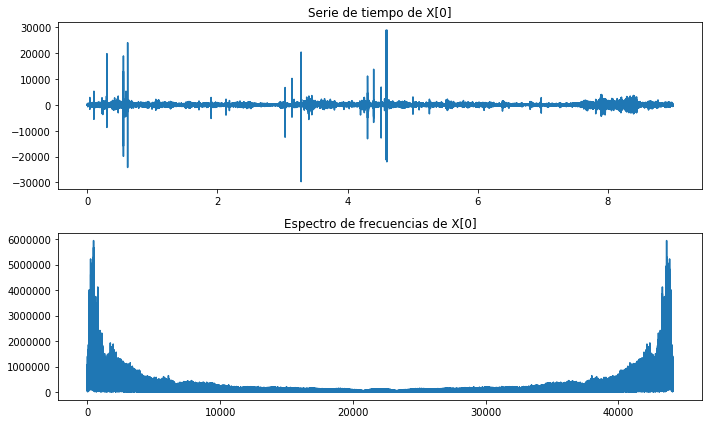

In [88]:
import matplotlib.pyplot as plt

plt.clf()

f, axarr = plt.subplots(2, figsize=(10,6))
axarr[0].plot(t_vector, X[0])
axarr[0].set_title('Serie de tiempo de X[0]')
axarr[1].plot(freq, X_fourier[0])
axarr[1].set_title('Espectro de frecuencias de X[0]')

plt.tight_layout()

plt.show()